In [11]:
from fipy import Grid3D, Grid2D, CellVariable, Viewer, numerix
from fipy import DiffusionTerm, ExplicitDiffusionTerm, TransientTerm, ImplicitDiffusionTerm
from IPython.display import clear_output

import numpy as np
import plotting_utils
import parameterfunctions as fct

from parameters import *

In [12]:
mesh = Grid3D(nx = N_x, ny = N_y, nz = N_z, dx = dx, dy = dy, dz = dz)

x = CellVariable(mesh = mesh, value = numerix.array(mesh.cellCenters)[0])
y = CellVariable(mesh = mesh, value = numerix.array(mesh.cellCenters)[1])
z = CellVariable(mesh = mesh, value = numerix.array(mesh.cellCenters)[2])

temperature = CellVariable(mesh = mesh, name = 'temperature', value=300.0)
pressure = CellVariable(mesh = mesh, name = 'pressure')
v_x = CellVariable(mesh = mesh, name = 'x-velocity', value=10.0)
v_y = CellVariable(mesh = mesh, name = 'y-velocity', value=0.0)
v_z = CellVariable(mesh = mesh, name = 'z-velocity', value=0.0)
sensible_heat = CellVariable(mesh = mesh, name = 'sensible heat', value=0.0)

velocity = CellVariable(mesh = mesh, name = 'velocity', rank = 1, value = numerix.array([numerix.array(v_x), numerix.array(v_y), numerix.array(v_z)]))

In [42]:
#starting values:
x_pos = 0.0001
layer = 5
hatch = 2.5
time = 0.0

#layer of laser impact:
N = round(mesh.nz / layers) * layer - 1

#initializing the parameters
liquid = fct.get_liquid_fraction(temperature, mesh, steel_T_S, steel_T_L)
molten_cells = CellVariable(mesh = mesh, name = 'molten cells', value = 0.0)
laser_factor = CellVariable(mesh = mesh, value = ((1-liquid)*steel_powder_absoprtion+liquid*steel_liquid_absoprtion)*distribution_factor*laser_power/(numerix.pi*beam_radius**2*layer_thickness))
c = (1-liquid)*fct.get_effective_specific_heat(argon_density, steel_density, packing_efficiency, argon_density, temperature, mesh) + liquid*steel_fluid_c
k = (1-liquid)*fct.get_effective_cond(mesh, temperature, packing_efficiency)+liquid*fct.get_steel_thermal_conductivity(mesh, temperature)
rho = fct.get_effective_density(argon_density, steel_density, packing_efficiency)*(1-liquid) + liquid*steel_density_liquid
alpha = k/(rho*c)

liquid_old = liquid

#initializing the source term 
source_value = laser_factor*numerix.exp(-distribution_factor*((x-x_pos)**2+(y-hatch*hatch_width)**2)/beam_radius**2)*dt
source = numerix.where(numerix.absolute(z-layer*layer_thickness) < layer_thickness, source_value, 0.0)
source_term = CellVariable(mesh = mesh, name = 'source', value=source)

konv_diff_eq = TransientTerm(var = sensible_heat) == DiffusionTerm(var = sensible_heat, coeff=alpha) + source_term - (liquid-liquid_old)*steel_latent_heat

#setting the dh/dz boundary condition
heat_radiation = -c.faceValue[mesh.facesTop]*sigma+steel_emissivity*(temperature.faceValue[mesh.facesTop]**4-300**4)/k.faceValue[mesh.facesTop]
sensible_heat.faceGrad[2].constrain(heat_radiation, where = mesh.facesTop)

c_measure = []
k_measure = []
t_measure = []
time_measure = []

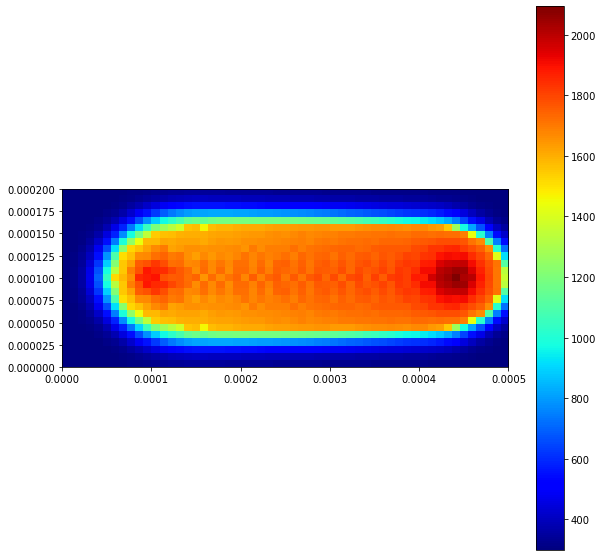

In [43]:
for i in range(time_steps):
    
    print(i)
    print(time)
    
    #setting new source term:
    laser_factor = CellVariable(mesh = mesh, value = ((1-liquid)*steel_powder_absoprtion+liquid*steel_liquid_absoprtion)*distribution_factor*laser_power/(numerix.pi*beam_radius**2*layer_thickness))
    source_value = laser_factor*numerix.exp(-distribution_factor*((x-x_pos)**2+(y-hatch*hatch_width)**2)/beam_radius**2)*dt
    source = numerix.where(numerix.absolute(z-layer*layer_thickness) < layer_thickness, source_value, 0.0)
    source_term.setValue(source)
    
    #determine the liquid/solid/molten state
    liquid_old.setValue(numerix.array(liquid))
    liquid = fct.get_liquid_fraction(temperature, mesh, steel_T_S, steel_T_L)
    molten_cells = fct.update_molten_cells(molten_cells, liquid)
    
    #update material paramters:
    c = fct.get_specific_heat(temperature, liquid, molten_cells, argon_density, steel_density, packing_efficiency, steel_T_S, steel_fluid_c)
    k = fct.get_thermal_conductivity(temperature, packing_efficiency, molten_cells, liquid, steel_cond_fluid, steel_T_S)
    rho = fct.get_effective_density(argon_density, steel_density, packing_efficiency)*(1-liquid) + liquid*steel_density_liquid
    alpha = k/(rho*c)
    
    #saving old heat for temperature change:
    heat_old = numerix.array(sensible_heat) 
    
    #finite-volume solving:
    konv_diff_eq = TransientTerm(var = sensible_heat) == DiffusionTerm(var = sensible_heat, coeff=alpha) + source_term - (liquid-liquid_old)*steel_latent_heat
    heat_radiation = -c.faceValue[mesh.facesTop]*sigma+steel_emissivity*(temperature.faceValue[mesh.facesTop]**4-300**4)/k.faceValue[mesh.facesTop]
    sensible_heat.faceGrad[2].constrain(heat_radiation, where = mesh.facesTop)
    
    res = konv_diff_eq.solve(dt = dt)
    del konv_diff_eq
    
    #calculate temperature change and add:
    temperature.setValue(numerix.array(temperature) + 1/c*(sensible_heat-heat_old)) 
    
    #updating laser position
    x_pos +=dt*scanning_speed
    time += dt
    clear_output()
    
    middle = -int(N_x*N_y/2)
    
    k_measure.append(numerix.array(k)[middle])
    c_measure.append(numerix.array(c)[middle])
    t_measure.append(numerix.array(temperature)[middle])
    time_measure.append(time)
    
    if x_pos >= L_x:
        
        hatch += 1
        x_pos = 0.0
        
        if hatch == hatches:
            
            layer += 1
            hatch = 0
            
            if layer == layers:
                
                break
                
plotting_utils.plot_2d_xy(temperature, N)

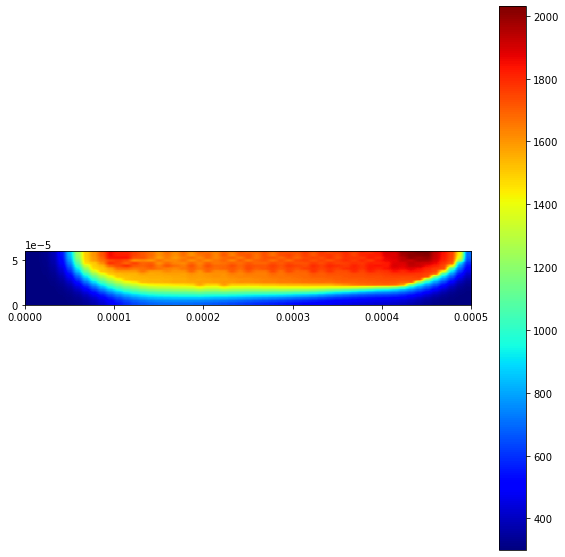

In [35]:
plotting_utils.plot_2d_xz(temperature, 13)

In [30]:
data = np.array(temperature)
np.save('temperature', data)

Text(0.5, 1.0, 'Conduction only')

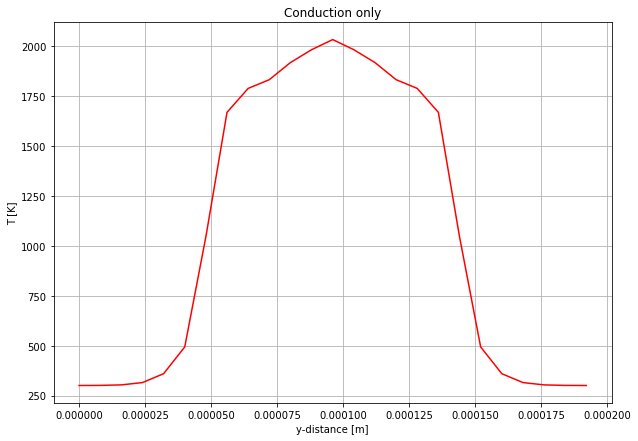

In [31]:
import matplotlib.pyplot as plt
data = np.load('temperature.npy')
temperature.setValue(data)

temp_final = np.array(temperature).reshape((N_z, N_y, N_x))
plt.figure(figsize = (10, 7))
plt.plot([i*dy for i in range(len(temp_final[-1, :, -7]))], temp_final[-1, :, -7], 'r-')
plt.grid()
plt.xlabel('y-distance [m]')
plt.ylabel('T [K]')
plt.title('Conduction only')
#plt.ylim((1693, 3093))

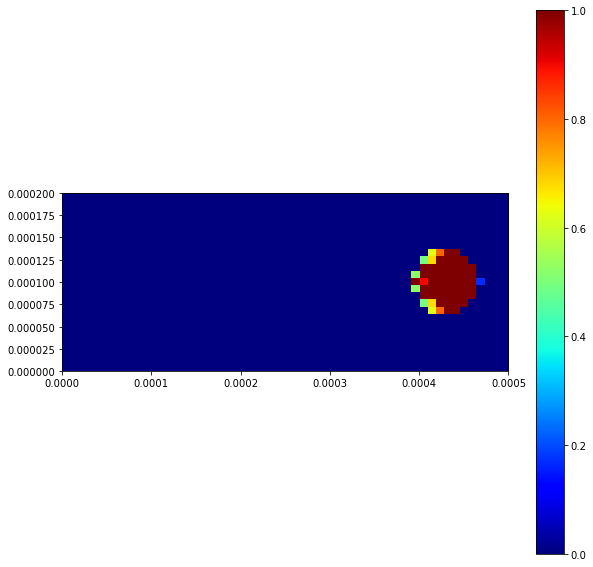

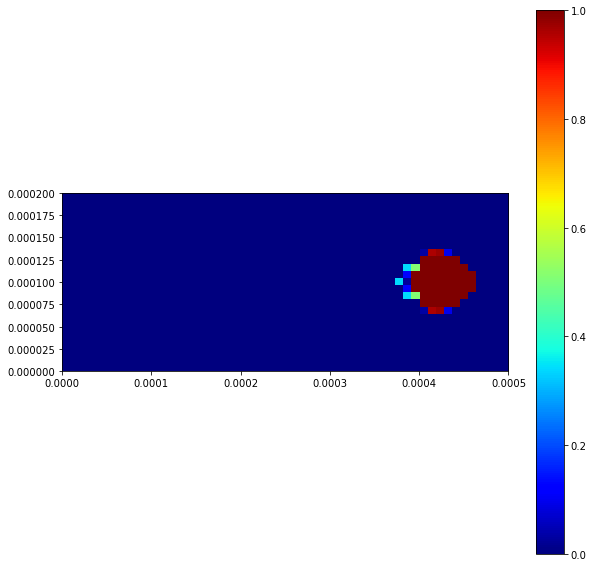

In [20]:
liquid = fct.get_liquid_fraction(temperature, mesh, steel_T_S, steel_T_L)
plotting_utils.plot_2d_xy(liquid, N)
plotting_utils.plot_2d_xy(liquid_old, N)

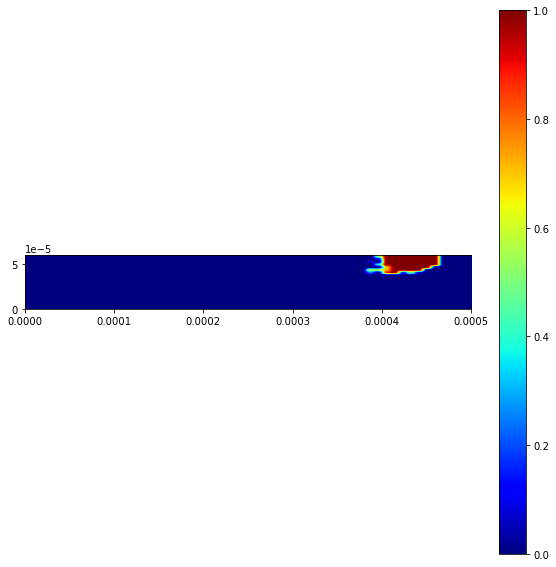

In [21]:
plotting_utils.plot_2d_xz(liquid, 13)

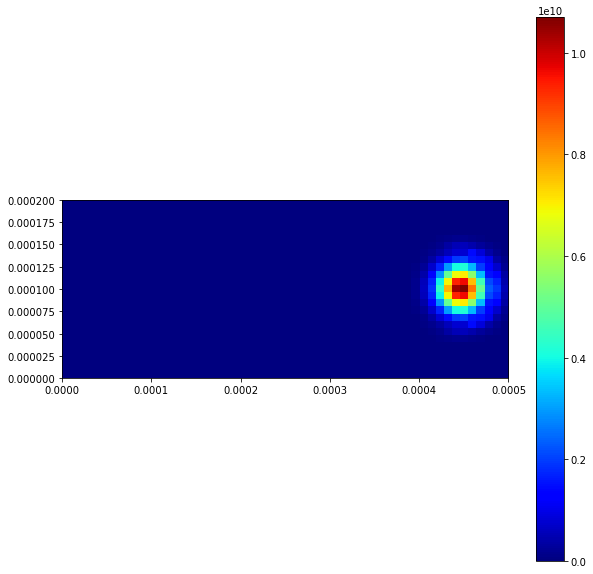

In [46]:
plotting_utils.plot_2d_xy(source_term, N)

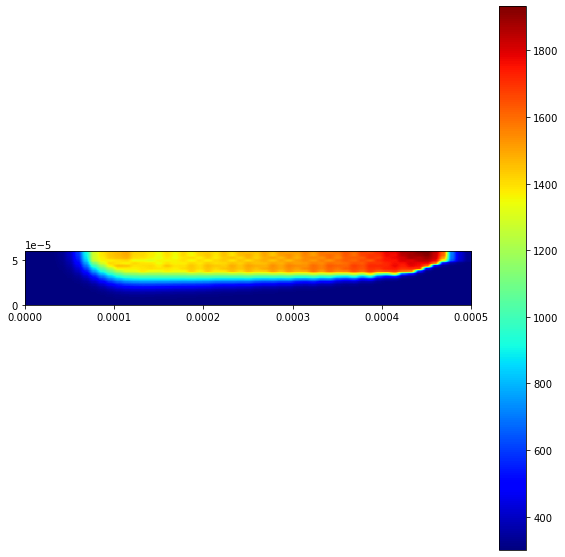

In [23]:
plotting_utils.plot_2d_xz(temperature, 13)

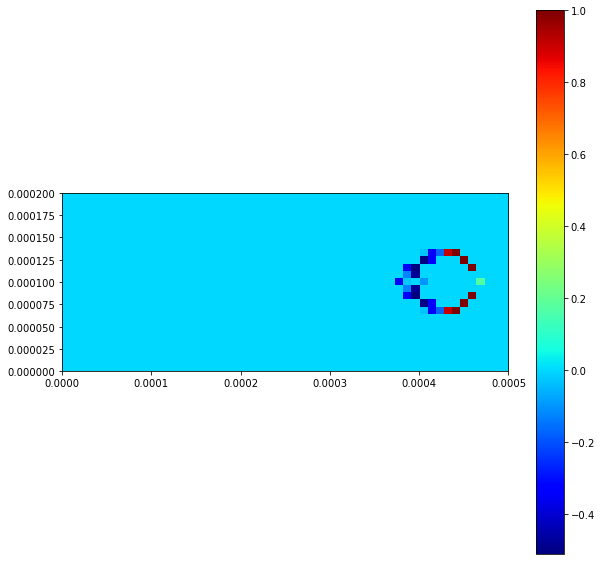

In [24]:
plotting_utils.plot_2d_xy(liquid-liquid_old, N)

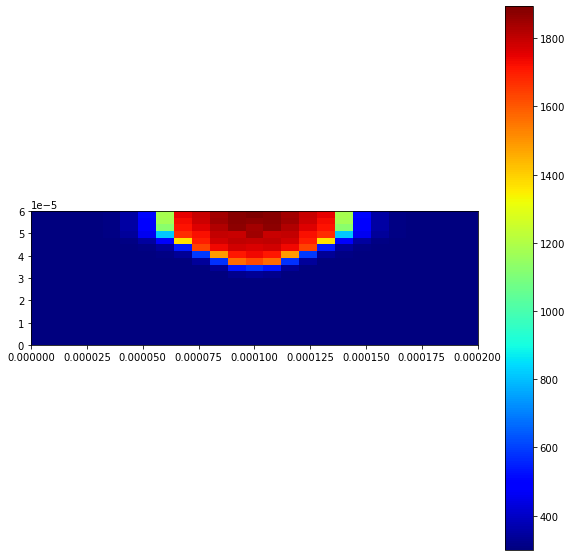

In [25]:
plotting_utils.plot_2d_yz(temperature, 47)

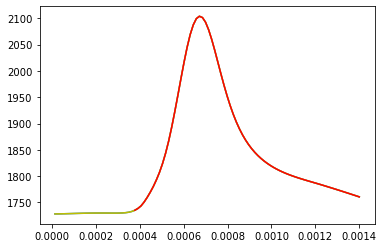

In [47]:
plt.plot(time_measure, t_measure)
plt.plot(np.array(time_measure)[np.array(t_measure)>steel_T_S], np.array(t_measure)[np.array(t_measure)>steel_T_S], 'y-')
plt.plot(np.array(time_measure)[np.array(t_measure)>steel_T_L], np.array(t_measure)[np.array(t_measure)>steel_T_L], 'r-')

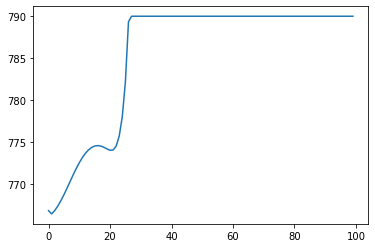

In [48]:
plt.plot(c_measure)

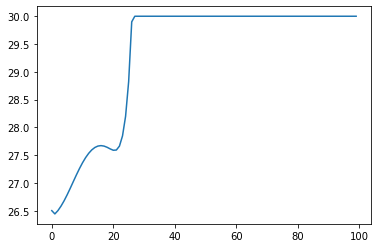

In [49]:
plt.plot(k_measure)